In [8]:
import numpy as np 
import pandas as pd 
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import plotly.graph_objects as go
sns.set_style('darkgrid')

from wordcloud import WordCloud,STOPWORDS
stopwords = list(STOPWORDS)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
df = pd.read_csv("TripAdvisorReviews.csv.csv")

In [11]:
df.head()

,4,"I was with my husband, and a few friends (5 of us total) and we had booked a two bedroom suite. Upon check in, the gal working the desk was super cute and friendly. She answered our million questions and gave us a brief little...More"
0,3,This place is an interesting mix of really coo...
1,5,"Yes, we know the rooms are outdated and funky ..."
2,5,"We went to the Grand Canyon from Phoenix, so v..."
3,4,"This is my second stay at Monte Vista, it was ..."
4,4,I am not sure why folks post such negative rev...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                     Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                     --------------  ----- 
 0   4                                                                                                                                                                                                                                          427 non-null    int64 
 1   I was with my husband, and a few friends (5 of us total) and we had booked a two bedroom suite. Upon c

In [13]:
# adding column name to the respective columns
df.columns =['Rating','Review']

In [14]:
df.shape

(427, 2)

In [15]:
# checking for null values
df.isnull().sum()

Rating    0
Review    0
dtype: int64

In [16]:
df.head()

,Rating,Review
0,3,This place is an interesting mix of really coo...
1,5,"Yes, we know the rooms are outdated and funky ..."
2,5,"We went to the Grand Canyon from Phoenix, so v..."
3,4,"This is my second stay at Monte Vista, it was ..."
4,4,I am not sure why folks post such negative rev...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  427 non-null    int64 
 1   Review  427 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.8+ KB


In [18]:
#Data Cleaning
import re

def  clean_text(text):
    """
    Fuction to clean the text data
    * symbols
    * change to lower_case
    """
    text = text.str.lower()
    text = text.apply(lambda T: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", T))  
        
    return text

In [19]:
df['Review']= clean_text(df['Review'])

df['Review'] = df['Review'].str.replace('#','')

df.head()

,Rating,Review
0,3,this place is an interesting mix of really coo...
1,5,yes we know the rooms are outdated and funky w...
2,5,we went to the grand canyon from phoenix so vi...
3,4,this is my second stay at monte vista it was o...
4,4,i am not sure why folks post such negative rev...


In [20]:
df["Rating"].value_counts()

4    149
3     83
5     77
1     74
2     44
Name: Rating, dtype: int64

In [21]:
df.loc[df["Review"] == ""]

,Rating,Review


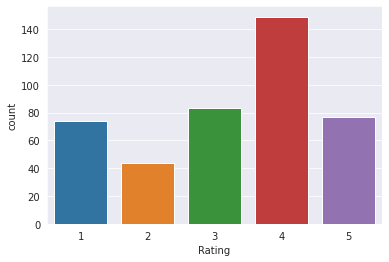

In [22]:
#Analysis

sns.countplot(x= df['Rating'])

In [23]:
df['WordCount']= df['Review'].map(lambda x: len(x.split()))

df.head()

,Rating,Review,WordCount
0,3,this place is an interesting mix of really coo...,45
1,5,yes we know the rooms are outdated and funky w...,45
2,5,we went to the grand canyon from phoenix so vi...,44
3,4,this is my second stay at monte vista it was o...,45
4,4,i am not sure why folks post such negative rev...,45


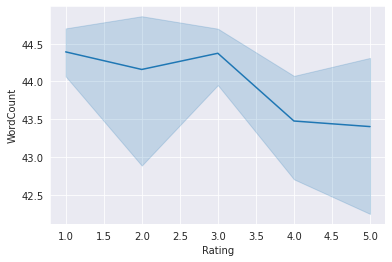

In [24]:
sns.lineplot(x='Rating', data=df, y='WordCount')

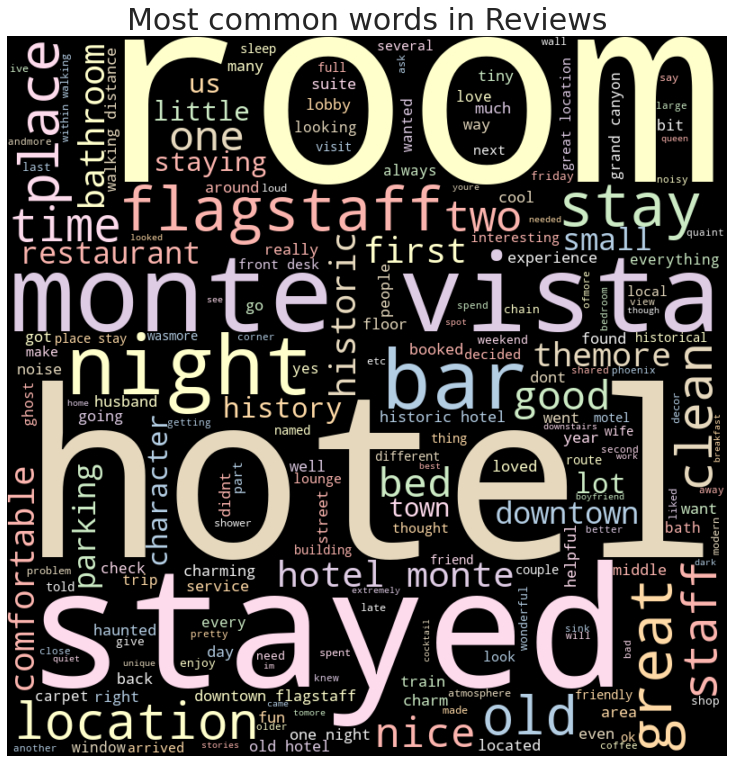

In [25]:
# Wordcloud of most common words

def wordCloud_generator(df):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10,
                          colormap='Pastel1'
                         ).generate(" ".join(df.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Most common words in Reviews",fontsize=30)
    plt.show() 
    
wordCloud_generator(df['Review'])

In [26]:
# Segregating and Encoding Positive, Neutral and Negative labels

pos = [5]
neg = [1, 2]
neu = [3, 4]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1  
df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

,Rating,Review,WordCount,Sentiment
0,3,this place is an interesting mix of really coo...,45,1
1,5,yes we know the rooms are outdated and funky w...,45,2
2,5,we went to the grand canyon from phoenix so vi...,44,2
3,4,this is my second stay at monte vista it was o...,45,1
4,4,i am not sure why folks post such negative rev...,45,1


In [27]:
#  Analysing Positive, Neutral and Negative Reviews

fig = go.Figure([go.Bar(x=df.Sentiment.value_counts().index, y=df.Sentiment.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()


**Text preprocessing**



Now let us preprocess Reviews using some NLP tchniques like:

    converting to lowercase
    Removing Punctuation
    Removing stopwords
    Stemming
    Lemmatization



In [28]:
import nltk
nltk.download('stopwords')

nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [29]:
punc=string.punctuation

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()

def data_preprocessing(txt):
    
    #converting to lowercase
    txt=txt.lower()
    
    #Removing Punctuation
    txt="".join([x for x in txt if x not in punc])
    
    #Removing stopwords
    txt=" ".join([word for word in str(txt).split() if word not in stop_words])
    
    #Stemming
    txt = " ".join([stemmer.stem(word) for word in txt.split()])
    
    #Lemmatization
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()])

    return txt

df['text'] = df['Review'].apply(data_preprocessing)

In [30]:
df

,Rating,Review,WordCount,Sentiment,text
0,3,this place is an interesting mix of really coo...,45,1,place interest mix realli cool room size nice ...
1,5,yes we know the rooms are outdated and funky w...,45,2,ye know room outdat funki charm histori isnt f...
2,5,we went to the grand canyon from phoenix so vi...,44,2,went grand canyon phoenix visit flagstaff opti...
3,4,this is my second stay at monte vista it was o...,45,1,second stay mont vista okay first time problem...
4,4,i am not sure why folks post such negative rev...,45,1,sure folk post neg review spot look gener chai...
...,...,...,...,...,...
422,1,we spent one of the most horrible nights of ou...,45,0,spent one horribl night live hotel need relax ...
423,1,we spent the first night and the worst night o...,45,0,spent first night worst night week long vacat ...
424,3,the staff was a little rude on the phone but a...,45,1,staff littl rude phone help need person mont v...
425,2,this hotel has a lot of character and an inter...,45,0,hotel lot charact interest histori definit lou...


**Bag Of Word (BOW)**

In [31]:
from sklearn.feature_extraction.text import CountVectorizer #Bag of Words

max_features = 500

count_vectorizer=CountVectorizer(max_features=max_features,stop_words="english") # stop words will be dropped by stopwords command

sparce_matrix=count_vectorizer.fit_transform(df).toarray()# this code will create matrix that consist of 0 and 1.

In [32]:
sparce_matrix.shape 

(5, 5)

In [33]:
sparce_matrix

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

***TF-IDF***

In [34]:
docs = list(df['Review'])[:7000]


**Create a TFIDF matrix out of it**

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 20000) 
 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [36]:
#tfidf_vectorizer.get_feature_names()

X = tfidf_vectorizer_vectors.toarray()
Y = df['Sentiment'][:7000]

In [37]:
len(X[0])

2759


Divide the data into training and validation sets

In [38]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier

SEED=123

X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)

In [39]:
fig = go.Figure([go.Bar(x=Y.value_counts().index, y=Y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Decision Tree Classifier

In [40]:
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.4419


In [41]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.33      0.33      0.33        24
     neutral       0.55      0.57      0.56        47
    negative       0.23      0.20      0.21        15

    accuracy                           0.44        86
   macro avg       0.37      0.37      0.37        86
weighted avg       0.43      0.44      0.44        86



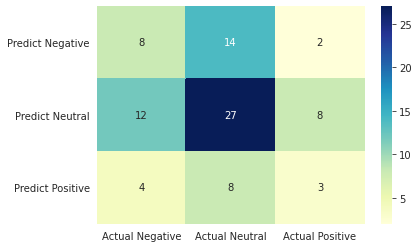

In [42]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()


Naive Bayes Classifier

In [43]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,gnb.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,gnb.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.4651


In [44]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.35      0.29      0.32        24
     neutral       0.52      0.68      0.59        47
    negative       0.20      0.07      0.10        15

    accuracy                           0.47        86
   macro avg       0.36      0.35      0.34        86
weighted avg       0.42      0.47      0.43        86



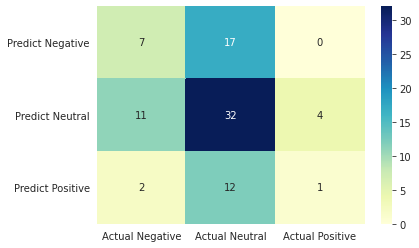

In [45]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Training Accuracy score: 0.8094
Testing Accuracy score: 0.5465


In [47]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.50      0.04      0.08        24
     neutral       0.55      0.98      0.70        47
    negative       0.00      0.00      0.00        15

    accuracy                           0.55        86
   macro avg       0.35      0.34      0.26        86
weighted avg       0.44      0.55      0.41        86



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



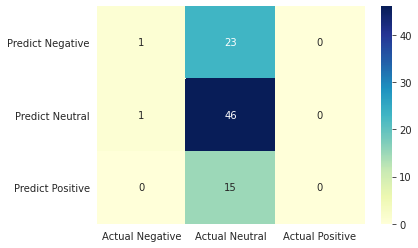

In [48]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,clf.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,clf.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5581


In [50]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.60      0.12      0.21        24
     neutral       0.56      0.96      0.70        47
    negative       0.00      0.00      0.00        15

    accuracy                           0.56        86
   macro avg       0.39      0.36      0.30        86
weighted avg       0.47      0.56      0.44        86



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



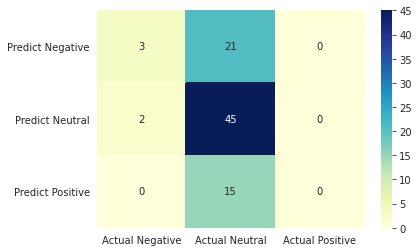

In [51]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Ensembling

In [52]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision Tree', dt),
               ('Logistic Regression', lr),
                ('Naive Bayes', gnb)
              ]
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)

print("Training Accuracy score: "+str(round(accuracy_score(y_train,vc.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,vc.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5
